In [2]:
from keras.layers import concatenate
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout, MaxPooling2D
from keras.models import Model
from keras.models import Sequential
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
data_train = pd.read_csv(
    'https://github.com/fpleoni/fashion_mnist/raw/master/fashion-mnist_train.csv')
X_full = data_train.iloc[:, 1:]
y_full = data_train.iloc[:, :1]
x_train, x_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3)

In [5]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [6]:
train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4186, 4236, 4253, 4169, 4189, 4128, 4214, 4257, 4198, 4170]
test groups: [1814, 1764, 1747, 1831, 1811, 1872, 1786, 1743, 1802, 1830]


In [7]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx]
                      [np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            non_group_idx = [np.random.choice(
                [i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx]
                      [np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]

    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

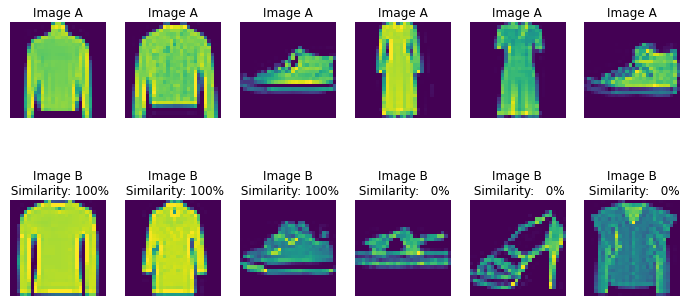

In [8]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:, :, 0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:, :, 0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [10]:
AlexNet = Sequential()

AlexNet.add(Conv2D(filters=96, input_shape=x_train.shape[1:], kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 7, 7, 96)          11712     
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 96)         384       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 7, 7, 96)          0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 batch_normalization_10 (Bat  (None, 4, 4, 256)       

In [11]:
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = AlexNet(img_a_in)
img_b_feat = AlexNet(img_b_in)
combined_features = concatenate(
    [img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[
                         combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 10)           25707274    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['sequential_1[0][

In [12]:
similarity_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

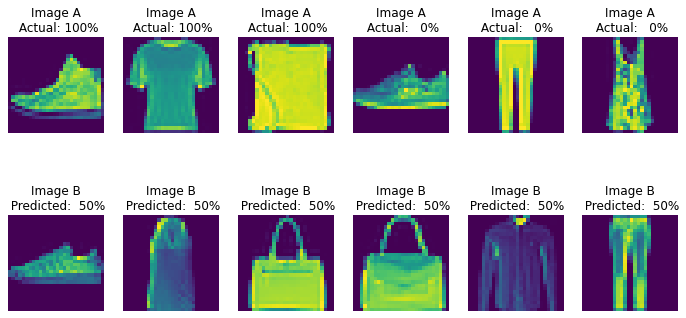

In [13]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

_ = show_model_output()

In [14]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                              steps_per_epoch=500,
                                              validation_data=(
                                                  [valid_a, valid_b], valid_sim),
                                              epochs=25,
                                              verbose=True)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


500/500 [==============================] - 551s 1s/step - loss: 0.5713 - mae: 0.3997 - val_loss: 0.4611 - val_mae: 0.3328
Epoch 2/25
500/500 [==============================] - 547s 1s/step - loss: 0.4264 - mae: 0.2923 - val_loss: 0.4047 - val_mae: 0.2518
Epoch 3/25
500/500 [==============================] - 549s 1s/step - loss: 0.3789 - mae: 0.2497 - val_loss: 0.4243 - val_mae: 0.2689
Epoch 4/25
500/500 [==============================] - 550s 1s/step - loss: 0.3577 - mae: 0.2324 - val_loss: 0.3686 - val_mae: 0.2102
Epoch 5/25
500/500 [==============================] - 547s 1s/step - loss: 0.3381 - mae: 0.2162 - val_loss: 0.3263 - val_mae: 0.1987
Epoch 6/25
500/500 [==============================] - 546s 1s/step - loss: 0.3172 - mae: 0.2015 - val_loss: 0.3032 - val_mae: 0.1816
Epoch 7/25
500/500 [==============================] - 556s 1s/step - loss: 0.3070 - mae: 0.1926 - val_loss: 0.3344 - val_mae: 0.1903
Epoch 8/25
500/500 [==============================] - 558s 1s/step - loss: 0.300

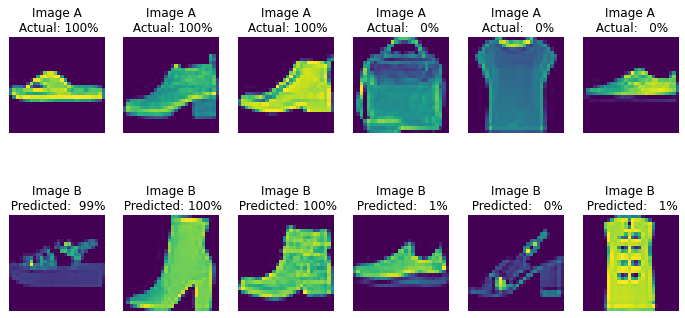

In [15]:
_ = show_model_output()

In [16]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0], 0)
t_shirt_score = similarity_model.predict(
    [t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0], 0)
ankle_boot_score = similarity_model.predict(
    [ankle_boot_vec, x_test], verbose=True, batch_size=128)

141/141 [==============================] - 53s 375ms/step


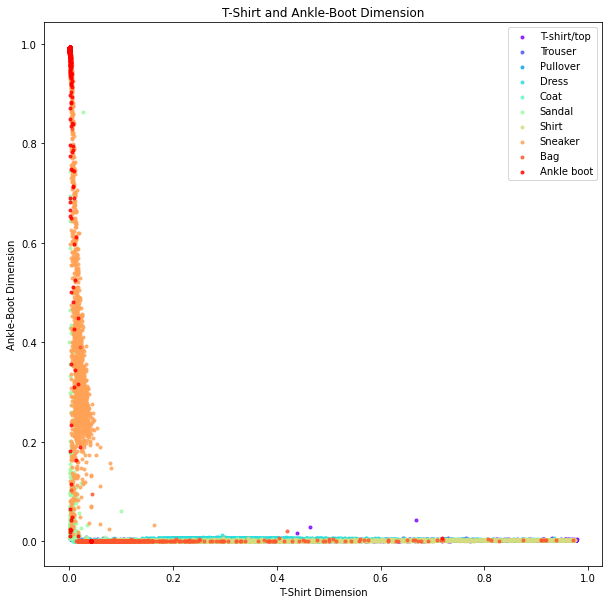

In [17]:
obj_categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                  'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [18]:
x_test_features = AlexNet.predict(x_test, verbose=True, batch_size=128)

141/141 [==============================] - 27s 187ms/step


In [19]:
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.026s...
[t-SNE] Computed neighbors for 18000 samples in 0.514s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 82.5487442, gradient norm = 0.0032209 (50 iterations in 7.956s)
[t-SNE] Iteration 100: error = 76.0435562, gradient norm = 0.0023509 (50 iterations in 7.632s)
[t-SNE] Iteration 150: error = 72.9236298, gradient norm = 0.0016389 (50 iterations in 7.602s)
[t-SNE] Iteration 200: error = 71.0543365, gradient norm = 0.0012614 (50 iterations in 7.582s)
[t-SNE] Iteration 250: error = 69.7901917, gradient norm = 0.0010050 (50 iterations in 7.600s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.790192
[t-SNE] Iteration 300: error = 2.8306339, gradient norm = 0.0011739 (50 iterations in 7.867s)
[t-SNE] Iteration 350: error = 2.2713428, gradient norm = 0.0006932 (50 iterations in 7.902s)
[t-SNE] Iteration 400: error = 1.8804116, gradient norm = 0.0004537 (50 iterations in 7.815s)
[t-SNE] Iteration 450: error = 1.6221683, gradient norm = 0.0003227 (50 iterations in 7.749s)
[t-SNE] Iteration 500: error = 1.4431584, gradient norm = 0.0002432 (50 

In [20]:
obj_categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                  'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

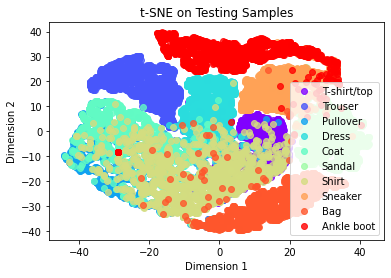

In [21]:
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)